# Kaggle Competition
## Javier Palomares

### Data Reading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
train = pd.read_csv('./input/train_final.csv')
test = pd.read_csv('./input/test_final.csv')

In [3]:
train.head()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [6]:
train.shape

(16383, 26)

In [3]:
x_train= train.loc[:,'f1':'f24']
x_train.shape

(16383, 24)

(array([1.6372e+04, 3.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.0085e+03, 2.0160e+03, 3.0235e+03, 4.0310e+03,
        5.0385e+03, 6.0460e+03, 7.0535e+03, 8.0610e+03, 9.0685e+03,
        1.0076e+04]),
 <a list of 10 Patch objects>)

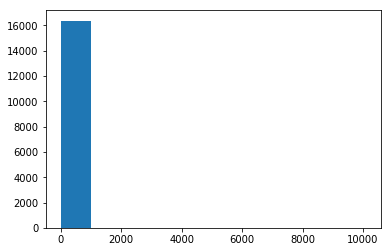

In [8]:
plt.hist(x_train.f12)

In [9]:
y = train.Y

(array([  948.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15435.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

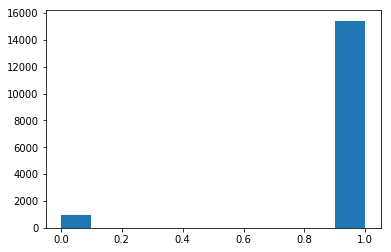

In [10]:
plt.hist(y)

It looks like the y variable is binary classification variable

In [231]:
x_train = train.loc[:,'f1':'f24']

In [22]:
x_test = test.loc[:,'f1':'f24']
ids = test.Id

### Data Preprocessing

In [232]:
# get the numberical features 
numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index
print(numeric_feats)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24'],
      dtype='object')


All features are numeric.

I'll find skewed features and drop those with a skewness greater than .85

In [233]:
# find skewed features
skew_to_drop = .85
#compute skewness
skewedness_factor = x_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewedness_factor[skewedness_factor > skew_to_drop].index
#f1 has a negative value, don't log transform f1
skewed_feats = skewed_feats.delete(0)

In [235]:
# take the log of skewed features
x_train[skewed_feats] = np.log1p(x_train[skewed_feats])

It looks like most of the features are skewed, but it also looks like several of the columns are integer valued

I'll look for binary columns and won't apply any preprocessing to those

In [11]:
def get_binary_cols(df):
    bin_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]
    return bin_cols

In [12]:
bin_cols = get_binary_cols(x_train)

In [13]:
print(bin_cols)

[]


There's no binary columns

In [96]:
# fill NA's with the mean of the column
x_train = x_train.fillna(x_train.mean())

### Models
I'll first try fitting a logistic regression classifier

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics
import datetime
# function to compute rmse error
def rmse(predicted,target):
    return np.sqrt(np.mean((predicted-target)**2))
# function to compute the root mean squared error of the cross validation
def rmse_cv(model,X_train,y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)
def auc_score(y_pred_proba,y):
    return metrics.roc_auc_score(y,y_pred_proba)
def write_predictions(filename,header,ids,y_pred):
    f = open(filename,'w')
    numRows = len(ids)
    f.write(header)
    for i in range(numRows):
        idNum = ids[i]
        y = y_pred[i]
        f.write("{},{}\n".format(idNum,y))
    f.close()
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

In [49]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas).tolist()
model_logistic = LogisticRegressionCV(Cs=alphas,cv=10,solver='liblinear').fit(x_train,y)

In [ ]:
rmse_cv(model_logistic,x_train,y).mean()

In [100]:
x_test = test.loc[:,'f1':'f24']
y_pred_proba = model_logistic.predict_proba(x_test)[:,1]
ids = test.Id

In [107]:
y_train_pred_proba = model_logistic.predict_proba(x_train)[:,1]
fpr,tpr, _ = metrics.roc_curve(y,y_train_pred_proba)
auc = metrics.auc(fpr,tpr)
print(auc)
metrics.roc_auc_score(y,y_train_pred_proba)

0.5321711163870813


0.5321711163870813

In [63]:

write_predictions("predictions/prediction"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_pred)

In [87]:
vanilla_logistic = LogisticRegression(C=1e-5,solver='lbfgs').fit(x_train,y)

In [88]:
y_pred_vanilla = vanilla_logistic.predict_proba(x_test)[:,1]

In [89]:
print(y_pred_vanilla)

[0.93979353 0.94021113 0.95522887 ... 0.94096549 0.93982833 0.93949173]


In [77]:
write_predictions("predictions/pure_vanilla_"+datetime.datetime.now().isoformat()+".csv","Id,Y\n",ids,y_pred_vanilla)

In [84]:
c = model_logistic.C_

In [90]:
vanilla_logistic.C

1e-05

Now trying XGBoost classifier

In [8]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
x_train = train.loc[:,'f1':'f24']
y = train.Y
x_test = test.loc[:,'f1':'f24']
ids = test.Id

* XGboost classifier with no normalization

In [10]:
model = XGBClassifier()
model.fit(x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
y_test_xgboost = model.predict_proba(x_test)[:,1]
y_train_xgboost = model.predict_proba(x_train)[:,1]

In [22]:
xg_boost_auc_score = auc_score(y_pred_proba=y_train_xgboost,y=y)

0.9057251451916913

xgboost scored 0.85731

This time, do some preprocessing

In [24]:
x_train = train.loc[:,'f1':'f24']
y = train.Y
x_test = test.loc[:,'f1':'f24']
ids = test.Id
# get the numberical features 
numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index
# find skewed features
skew_to_drop = .75
#compute skewness
skewedness_factor = x_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewedness_factor[skewedness_factor > skew_to_drop].index
#f1 has a negative value, don't log transform f1
skewed_feats = skewed_feats.delete(0)
# take the log of skewed features
x_train[skewed_feats] = np.log1p(x_train[skewed_feats])
x_test[skewed_feats] = np.log1p(x_train[skewed_feats])

In [26]:
model_xg_boost_norm = XGBClassifier()
model_xg_boost_norm.fit(x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
y_test_xgboost_norm = model_xg_boost_norm.predict_proba(x_test)[:,1]
y_train_xgboost_norm = model_xg_boost_norm.predict_proba(x_train)[:,1]

In [40]:
auc_score(y_pred_proba =y_train_xgboost_norm,y=y )

0.9057251451916913

In [35]:
write_predictions("predictions/xgboost_normalized"+datetime.datetime.now().isoformat()+".csv","Id,Y\n",ids,y_test_xgboost_norm)

xgboost + normalization scored 0.82317, not an improvement

Next, try dropping non important features, also optimizing over a bigger range of values for xgboost

now trying tensorflow

In [41]:
import tensorflow as tf

In [45]:
feature_count = x_train.shape[1]
label_count = y.shape[0]
print(feature_count, label_count)

24 16383


In [46]:
# inputs
training_epochs = 3000
learning_rate = 0.01
hidden_layers = feature_count - 1
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.float32,[None,label_count])
is_training=tf.Variable(True,dtype=tf.bool)

Instructions for updating:
Colocations handled automatically by placer.


In [47]:
# models

initializer = tf.contrib.layers.xavier_initializer()
h0 = tf.layers.dense(X, hidden_layers, activation=tf.nn.relu, kernel_initializer=initializer)
# h0 = tf.nn.dropout(h0, 0.95)
h1 = tf.layers.dense(h0, label_count, activation=None)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=h1)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.


* Keras classifier

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [13]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [14]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [15]:
results = cross_val_score(estimator, x_train, y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [22]:
estimator.fit(x_train,y)

In [23]:
keras_pred = estimator.predict_proba(x_test)

In [27]:
keras_pred = keras_pred[:,1]

In [29]:
max(keras_pred)
# predicts everything as one. Need to balance number of samples. do that and then standardize data

1.0